In [1]:
scores = '../out/ko_scores_rep.txt'
orig = '../out/ko_scores.txt'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

In [4]:
def get_variance_function(v,
                          slices=10,
                          min_periods=20,
                          sample=None,
                          function=pd.Series.var):
    x = []
    y = []
    z = []
    vmin = v['sum'].min()
    vmax = v['sum'].max()
    lv = None
    for rv in np.linspace(vmin, vmax, slices):
        if lv is None:
            lv = rv
            continue
        vs = v[(v['sum'] >= lv) & (v['sum'] <= rv)]
        if vs.shape[0] < min_periods:
            lv = rv
            continue
        if sample is not None:
            var = function(vs['sub'].sample(sample,
                                            replace=True))
            mean = vs['sub'].sample(sample,
                                    replace=True).mean()
        else:
            var = function(vs['sub'])
            mean = vs['sub'].mean()
        x.append((lv + rv) / 2)
        y.append(var)
        z.append(mean)
    return x, y, z

In [5]:
m = pd.read_table(scores, index_col=[3, 1, 0, 2, 5])

Batches reproducibility
---

In [6]:
b1 = m.loc['B1']
b2 = m.loc['B2']

In [7]:
res = []
for c in {x[0]
          for x in b1.index}.intersection({x[0]
                                           for x in b2.index}):
    m1 = b1.loc[c]
    m2 = b2.loc[c]
    c1 = set(m1.index)
    c2 = set(m2.index)
    idx = sorted(c1.intersection(c2))
    a1 = m1.loc[idx]['score']
    a2 = m2.loc[idx]['score']
    if len(idx) > 10:
        r, p = stats.pearsonr(a1, a2)
        res.append((c, r, p))
r = pd.DataFrame(res,
                 columns=['condition',
                          'r', 'p'])

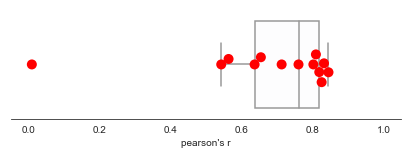

In [8]:
plt.figure(figsize=(7, 2))

sns.boxplot(data=r,
            x='r',
            color=sns.xkcd_rgb['pale grey'])
sns.swarmplot(data=r,
              x='r',
              size=10,
              color='r')
plt.xlim(-0.05, 1.05)
plt.xlabel('pearson\'s r')
sns.despine(left=True);

In [9]:
r.sort_values('r')

,condition,r,p
9,Anaerobic growth (48H),0.009532,0.462618
10,DMSO 1% (48H),0.542892,0.000000
1,Amphotericin B (48H),0.563539,0.000000
12,SC + hepes (48H),0.636900,0.000000
5,Sorbitol 1M (48H),0.654519,0.000000
7,6-AU (48H),0.713007,0.000000
0,39ºC (48H),0.760533,0.000000
2,Glycerol 2% (72H),0.802362,0.000000
8,Glycerol 2% (48H),0.809538,0.000000
3,Caffeine 20mM (48H),0.818977,0.000000


Batches reproducibility as a way to spot significant s-scores differences
---

In [10]:
c1 = set(b1.index)
c2 = set(b2.index)
idx = sorted(c1.intersection(c2))
cdx = set(r[r['r'] >= 0.5]['condition'])
mdx = [x for x in idx
       if x[0] in cdx]
a1 = b1.loc[idx]['score']
a2 = b2.loc[idx]['score']
d1 = b1.loc[mdx]['score']
d2 = b2.loc[mdx]['score']

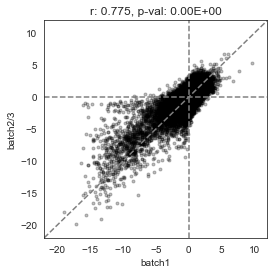

In [11]:
plt.figure(figsize=(4, 4))

plt.plot(d1,
         d2,
         'k.',
         alpha=0.25)
plt.plot([-22, 12],
         [-22, 12],
         '--',
         color='grey')

plt.xlim(-22, 12)
plt.ylim(-22, 12)

plt.axvline(0,
            color='grey',
            linestyle='dashed')
plt.axhline(0,
            color='grey',
            linestyle='dashed')

plt.xlabel('batch1')
plt.ylabel('batch2/3')

r, p = stats.pearsonr(d1,
                      d2)

plt.title('r: %.3f, p-val: %.2E' % (r, p));

In [12]:
d1.name = 'batch1'
d2.name = 'batch2/3'
v1 = -abs(d1 + d2)
v2 = abs(d1 - d2)
v1.name = 'sum'
v2.name = 'sub'
v = d1.to_frame().join(d2.to_frame())
v = v.join(v1.to_frame()).join(v2.to_frame())
x, y, z = get_variance_function(v, 100,
                                function=pd.Series.std)
v['var'] = np.interp(-abs(d1 + d2),
                     x,
                     y)
v['mean'] = np.interp(-abs(d1 + d2),
                     x,
                     z)
v['pval'] = [1 - stats.norm.cdf(x, loc=z, scale=y)
             for x,y,z in v[['sub', 'var', 'mean']].values]
v['qval'] = sm.stats.multipletests(v['pval'], method='fdr_bh')[1]

In [13]:
o = pd.read_table(orig, index_col=[0, 1, 2])['score']
o1 = o.loc['S288C']
o1.name = 'S288C'
o1 = o1[~o1.index.duplicated()].dropna()
o2 = o.loc['YPS']
o2.name = 'YPS'
o2 = o2[~o2.index.duplicated()].dropna()
oo = o1.to_frame().join(o2.to_frame(), how='inner').dropna()
a1 = oo['S288C']
a2 = oo['YPS']
v1 = -abs(a1 + a2)
v2 = abs(a1 - a2)
v1.name = 'sum'
v2.name = 'sub'
w = a1.to_frame().join(a2.to_frame())
w = w.join(v1.to_frame()).join(v2.to_frame())
w['var'] = np.interp(-abs(a1 + a2),
                     x,
                     y)
w['mean'] = np.interp(-abs(a1 + a2),
                     x,
                     z)
w['pval'] = [1 - stats.norm.cdf(x, loc=z, scale=y)
             for x,y,z in w[['sub', 'var', 'mean']].values]
w['qval'] = sm.stats.multipletests(w['pval'], method='fdr_bh')[1]

In [14]:
v['qval'] = v['pval']
w['qval'] = w['pval']

In [15]:
v['qval'] = sm.stats.multipletests(v['pval'], method='fdr_bh')[1]
w['qval'] = sm.stats.multipletests(w['pval'], method='fdr_bh')[1]

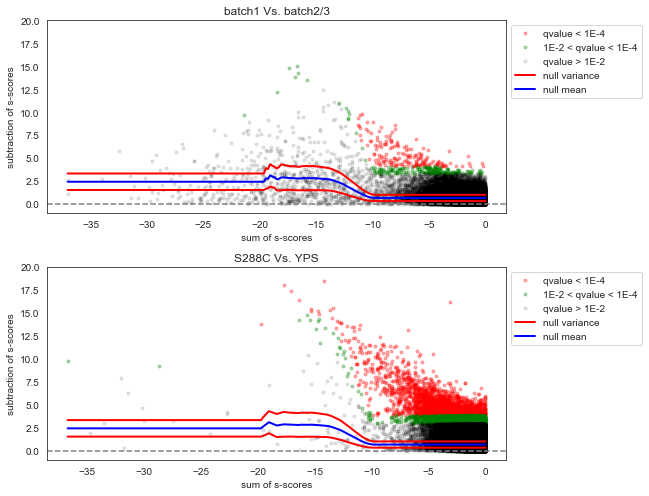

In [16]:
plt.figure(figsize=(9, 7))

plt.subplot(211)

plt.plot(v[(v['qval'] < 1E-4)]['sum'],
         v[(v['qval'] < 1E-4)]['sub'],
         'r.',
         alpha=0.3,
         label='qvalue < 1E-4')
plt.plot(v[(v['qval'] < 1E-2) & (v['qval'] >= 1E-4)]['sum'],
         v[(v['qval'] < 1E-2) & (v['qval'] >= 1E-4)]['sub'],
         'g.',
         alpha=0.3,
         label='1E-2 < qvalue < 1E-4')
plt.plot(v[v['qval'] >= 1E-2]['sum'],
         v[v['qval'] >= 1E-2]['sub'],
         'k.',
         alpha=0.1,
         label='qvalue > 1E-2')
plt.plot(v.sort_values('sum')['sum'],
         v.sort_values('sum')['mean'] + (v.sort_values('sum')['var'] / 2),
         'r-',
         lw=2,
         label='null variance')
plt.plot(v.sort_values('sum')['sum'],
         v.sort_values('sum')['mean'] - (v.sort_values('sum')['var'] / 2),
         'r-',
         lw=2,
         label='_')
plt.plot(v.sort_values('sum')['sum'],
         v.sort_values('sum')['mean'],
         'b-',
         lw=2,
         label='null mean')

# plt.xlim(-40, 20)
plt.ylim(-1, 20)

plt.axhline(0,
            color='grey',
            linestyle='dashed')

plt.xlabel('sum of s-scores')
plt.ylabel('subtraction of s-scores')

plt.legend(frameon=True,
           bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('batch1 Vs. batch2/3')

plt.subplot(212)

plt.plot(w[(w['qval'] < 1E-4)]['sum'],
         w[(w['qval'] < 1E-4)]['sub'],
         'r.',
         alpha=0.3,
         label='qvalue < 1E-4')
plt.plot(w[(w['qval'] < 1E-2) & (w['qval'] >= 1E-4)]['sum'],
         w[(w['qval'] < 1E-2) & (w['qval'] >= 1E-4)]['sub'],
         'g.',
         alpha=0.3,
         label='1E-2 < qvalue < 1E-4')
plt.plot(w[w['qval'] >= 1E-2]['sum'],
         w[w['qval'] >= 1E-2]['sub'],
         'k.',
         alpha=0.1,
         label='qvalue > 1E-2')
plt.plot(w.sort_values('sum')['sum'],
         w.sort_values('sum')['mean'] + (w.sort_values('sum')['var'] / 2),
         'r-',
         lw=2,
         label='null variance')
plt.plot(w.sort_values('sum')['sum'],
         w.sort_values('sum')['mean'] - (w.sort_values('sum')['var'] / 2),
         'r-',
         lw=2,
         label='_')
plt.plot(w.sort_values('sum')['sum'],
         w.sort_values('sum')['mean'],
         'b-',
         lw=2,
         label='null mean')

# plt.xlim(-40, 20)
plt.ylim(-1, 20)

plt.axhline(0,
            color='grey',
            linestyle='dashed')

plt.xlabel('sum of s-scores')
plt.ylabel('subtraction of s-scores')

plt.legend(frameon=True,
           bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('S288C Vs. YPS')

plt.tight_layout();

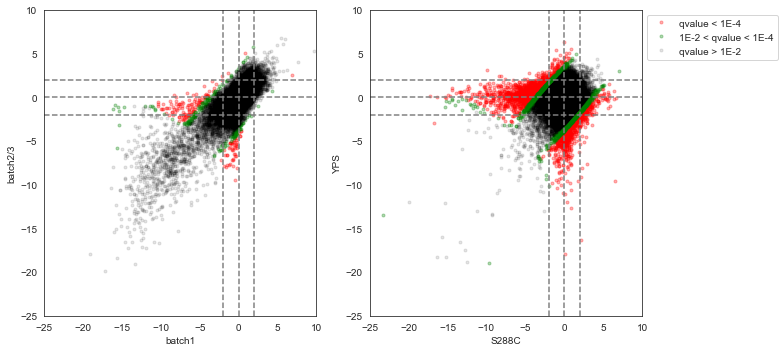

In [17]:
plt.figure(figsize=(11, 5))

plt.subplot(121)

plt.plot(v[(v['qval'] < 1E-4)]['batch1'],
         v[(v['qval'] < 1E-4)]['batch2/3'],
         'r.',
         alpha=0.3,
         label='qvalue < 1E-4')
plt.plot(v[(v['qval'] < 1E-2) & (v['qval'] >= 1E-4)]['batch1'],
         v[(v['qval'] < 1E-2) & (v['qval'] >= 1E-4)]['batch2/3'],
         'g.',
         alpha=0.3,
         label='1E-2 < qvalue < 1E-4')
plt.plot(v[v['qval'] >= 1E-2]['batch1'],
         v[v['qval'] >= 1E-2]['batch2/3'],
         'k.',
         alpha=0.1,
         label='qvalue > 1E-2')

plt.axhline(0,
            color='grey',
            linestyle='dashed')
plt.axvline(0,
            color='grey',
            linestyle='dashed')
plt.axhline(-2,
            color='grey',
            linestyle='dashed')
plt.axvline(-2,
            color='grey',
            linestyle='dashed')
plt.axhline(2,
            color='grey',
            linestyle='dashed')
plt.axvline(2,
            color='grey',
            linestyle='dashed')

plt.xlim(-25, 10)
plt.ylim(-25, 10)

plt.xlabel('batch1')
plt.ylabel('batch2/3')

plt.subplot(122)

plt.plot(w[(w['qval'] < 1E-4)]['S288C'],
         w[(w['qval'] < 1E-4)]['YPS'],
         'r.',
         alpha=0.3,
         label='qvalue < 1E-4')
plt.plot(w[(w['qval'] < 1E-2) & (w['qval'] >= 1E-4)]['S288C'],
         w[(w['qval'] < 1E-2) & (w['qval'] >= 1E-4)]['YPS'],
         'g.',
         alpha=0.3,
         label='1E-2 < qvalue < 1E-4')
plt.plot(w[w['qval'] >= 1E-2]['S288C'],
         w[w['qval'] >= 1E-2]['YPS'],
         'k.',
         alpha=0.1,
         label='qvalue > 1E-2')

plt.axhline(0,
            color='grey',
            linestyle='dashed')
plt.axvline(0,
            color='grey',
            linestyle='dashed')
plt.axhline(-2,
            color='grey',
            linestyle='dashed')
plt.axvline(-2,
            color='grey',
            linestyle='dashed')
plt.axhline(2,
            color='grey',
            linestyle='dashed')
plt.axvline(2,
            color='grey',
            linestyle='dashed')

plt.xlim(-25, 10)
plt.ylim(-25, 10)

plt.xlabel('S288C')
plt.ylabel('YPS')

plt.legend(frameon=True,
           bbox_to_anchor=(1, 1),
           loc='upper left')

plt.tight_layout();

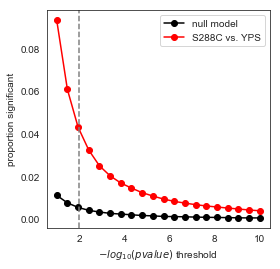

In [18]:
plt.figure(figsize=(4, 4))

plt.plot(np.linspace(1, 10, 20),
         [v[v['qval'] < np.power(10., -i)].shape[0] / v.shape[0] for i in np.linspace(1, 10, 20)],
         'ko-',
         label='null model')

plt.plot(np.linspace(1, 10, 20),
         [w[w['qval'] < np.power(10., -i)].shape[0] / w.shape[0] for i in np.linspace(1, 10, 20)],
         'ro-',
         label='S288C vs. YPS')

plt.xlabel('$-log_{10}(pvalue)$ threshold')
plt.ylabel('proportion significant')

plt.axvline(2,
            linestyle='dashed',
            color='grey')

plt.legend(frameon=True);

<h5><a href="javascript:toggle()" target="_self">toggle source code</a></h5>